In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, make_scorer
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
%matplotlib inline

In [2]:
data = pd.read_csv("monthly-sunspots.csv", index_col=0)
get_index = lambda x: lambda date: int(date.split("-")[x])
data.rename(columns={"Monthly Mean Total Sunspot Number": "sunspots"}, inplace=True)
data["Year"] = data.Date.apply(get_index(0))
data["Month"] = data.Date.apply(get_index(1))
data["Day"] = data.Date.apply(get_index(2))
data.head(3)

,Date,sunspots,Year,Month,Day
0,1749-01-31,96.7,1749,1,31
1,1749-02-28,104.3,1749,2,28
2,1749-03-31,116.7,1749,3,31


In [3]:
train_split = data.query("Year < 2010").sunspots.values.reshape(-1, 1)
test_split = data.query("Year >= 2010").sunspots.values.reshape(-1, 1)
print("Treino:", len(train_split), "amostras.")
print("Teste:", len(test_split), "amostras.")

Treino: 3132 amostras.
Teste: 120 amostras.


Temos 3132 amostras, então contanto que K seja menor que 3131 não precisaremos usar o Lagrangiano e poderemos utilizar mínimos quadrados.

In [4]:
MSE = make_scorer(mean_squared_error)

class AutoregressiveEstimator(BaseEstimator):
    def __init__(self, K=1, use_only_existing=False):
        self.K = K
        self.use_only_existing = use_only_existing
    
    def get_params(self, deep=None):
        return {
            "K": self.K
        }
    
    def set_params(self, **params):
        self.K = params.get("K", self.K)
        return self
    
    def create_features(self, x):
        x = x.flatten()
        # Create placeholder
        x_ = np.zeros((len(x), self.K))
        # Take past values of x
        for i in range(1, self.K + 1):
            x_[i:, i - 1] = x[:-i]
        # Use only past values
        if self.use_only_existing:
            x_ = x_[self.K:]
        # Bias input
        x = self.concat_bias_column(x_)
        return x
    
    def concat_bias_column(self, x):
        bias = np.ones((len(x), 1))
        x = np.concatenate([bias, x], axis=1)
        return x
    
    def create_labels(self, x):
        if self.use_only_existing:
            return x[self.K:]
        return x
    
    def fit(self, x, y=None):
        y = self.create_labels(x)
        x = self.create_features(x)
        rank = np.linalg.matrix_rank(x[:, 1:])
        
        # Check the rank to make sure that x.T*x is invertible
        assert rank == self.K, f"Rank is {rank}, less than K"
        A = np.linalg.inv(np.matmul(x.T, x))
        B = np.matmul(x.T, y)
        self.W = np.matmul(A, B)
        return self
    
    def score(self, x, y=None):
        y = self.create_labels(x)
        
        # Using the RMSE function as a scoring function (minimizing -1 times the RMSE equals minimizing the RMSE)
        return - mean_squared_error(y, self.predict(x), squared=False)
        
    def predict(self, x):
        x = self.create_features(x)
        return np.matmul(x, self.W)
K_range = range(1, 24 + 1)
grid_search = GridSearchCV(AutoregressiveEstimator(), param_grid={"K": K_range}, cv=5)

In [5]:
model = AutoregressiveEstimator(K=3)
created = model.create_features(train_split)[:5]
labels = train_split[:5]
print("Features used", created)
print("Labels used", labels)

Features used [[  1.    0.    0.    0. ]
 [  1.   96.7   0.    0. ]
 [  1.  104.3  96.7   0. ]
 [  1.  116.7 104.3  96.7]
 [  1.   92.8 116.7 104.3]]
Labels used [[ 96.7]
 [104.3]
 [116.7]
 [ 92.8]
 [141.7]]


In [6]:
grid_search.fit(train_split, y=None)

GridSearchCV(cv=5, error_score=nan, estimator=AutoregressiveEstimator(K=1),
             iid='deprecated', n_jobs=None, param_grid={'K': range(1, 25)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Best RMSE: 25.88700357629449
Best K: 0


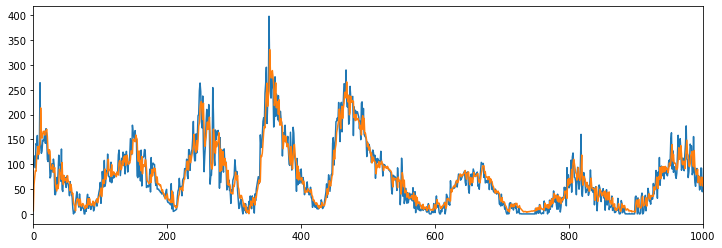

In [7]:
model = grid_search.best_estimator_
K = grid_search.best_params_["K"]
K = K if model.use_only_existing else 0
best_rmse = - grid_search.best_score_
plt.figure(figsize=(12, 4))
plt.plot(train_split)
plt.plot(range(K, len(train_split)), model.predict(train_split))
plt.xlim([0, 1000])
print("Best RMSE:", best_rmse)
print("Best K:", K)

Best RMSE: 25.88700357629449


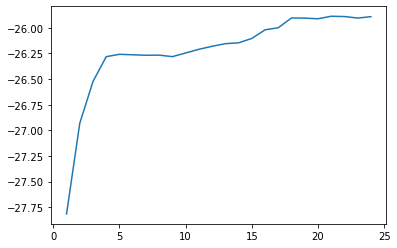

In [8]:
K_values = [params["K"] for params in grid_search.cv_results_["params"]]
plt.plot(K_values, grid_search.cv_results_["mean_test_score"])
print("Best RMSE:", -grid_search.best_score_)

## Parte 2

In [9]:
from sklearn.metrics import mean_squared_error, make_scorer
from functools import partial

class AutoregressiveELMRidgeEstimator(AutoregressiveEstimator):
    def __init__(self, K=20, T=20, alpha=1e-3, use_only_existing=False, seed=4, scaler=None):
        self.K = K
        self.T = T
        self.use_only_existing = use_only_existing
        self.scaler = scaler
        self.seed = seed
        self.alpha = alpha
        self.verbose=False

    def get_params(self, deep=None):
        return {
            "K": self.K,
            "T": self.T,
            "alpha": self.alpha,
            "scaler": self.scaler
        }
    
    def set_params(self, **params):
        self.K = params.get("K", self.K)
        self.T = params.get("T", self.T)
        self.alpha = params.get("alpha", self.alpha)
        self.scaler = params.get("scaler", self.scaler)
        return self
    
    def create_elm_weights(self):
        np.random.seed(self.seed)
        # Transformation weights are initialized with a random uniform distribution.
        self.ELM_weights = np.random.rand(self.T, self.K)
        
    def create_labels(self, x):
        if self.scaler:
            x = self.scaler.transform(x)
        if self.use_only_existing:
            return x[self.K:]
        return x
    
    def create_features(self, x):
        if self.scaler:
            x = self.scaler.transform(x)
        x = x.flatten()
        # Create placeholder
        x_ = np.zeros((len(x), self.K))
        # Take K past values of x
        for i in range(1, self.K + 1):
            x_[i:, i - 1] = x[:-i]
        # Use only past values
        if self.use_only_existing:
            x_ = x_[self.K:]

        # Project them into random feature space
        if self.T:
            a = x_.copy()
            x_ = np.matmul(self.ELM_weights, x_.T).T
            x_ = np.tanh(x_)
            assert (x_.max() < 0.8) and (x_.min() > -0.8), "Max: {} | Min: {}".format(x_.max(), x_.min())
        # Bias input
        # x = self.concat_bias_column(x_)
        if self.verbose:
            print("CREATED", x_.max(), x_.min())
        return x_
    
    def identity_prime(self):
        size = self.T if self.T else self.K
        ip = np.identity(size)
        ip[0, 0] = 0
        return ip
    
    def fit(self, x, y=None):
        self.create_elm_weights()
        if self.scaler is not None:
            self.scaler.fit(x.reshape(-1, 1))
        
        y = self.create_labels(x)
        x = self.create_features(x)
        A = np.linalg.inv(np.matmul(x.T, x) + self.alpha*self.identity_prime())
        B = np.matmul(x.T, y)
        self.W = np.matmul(A, B)
        return self
    
    def score(self, x, y=None):
        y = self.scaler.inverse_transform(self.create_labels(x))
        pred = self.predict(x)
        return - mean_squared_error(y, pred, squared=False)
        
        
    def set_verbose(self):
        self.verbose=True
    
    def predict(self, x):
        x = self.create_features(x)
        pred = np.matmul(x, self.W)
        if self.scaler:
            pred = self.scaler.inverse_transform(pred)
        return pred

Data is scaled between -1/K and 1/K because in the matrix multiplication:

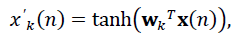

The values of $w_k^Tx(n)$ will be bounded between 1/K * K = 1, so the value of the elements in $tanh(w_k^Tx(n))$ will be bounded between $-0.7616$ and $0.7616$, and the $tanh$ function will not "saturate".

We will use a 5-fold cross validation scheme, and the values of alpha will vary from $10^{-10}$ to $10^{10}$, in a geometric progression.

In [10]:
from sklearn.preprocessing import MinMaxScaler
import tqdm

results = []

# K is fixed in 8
K = 8

T_vector = np.arange(1, 100 + 1, 1)

scaler = MinMaxScaler(feature_range=(-1/K, 1/K))

# For each T from 1 to 100...
for t in tqdm.tqdm(T_vector):

    grid_search = GridSearchCV(
        AutoregressiveELMRidgeEstimator(scaler=scaler, seed=111),
        param_grid={
            "K": [K],
            "T": [t],
            "alpha": np.logspace(-10, 10, 50)
        },
        cv=5,
        verbose=0,
        n_jobs=3,
        refit=True
    )
    grid_search.fit(train_split, y=None)
    
    # Saving the results
    result = {
        "score": grid_search.best_score_,
        "alpha": grid_search.best_params_["alpha"],
        "T": t,
        "K": K,
        "model": grid_search.best_estimator_
    }
    plt.show()
    results.append(result)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:21<00:00,  1.41s/it]


Best RMSE: 25.904712666706537


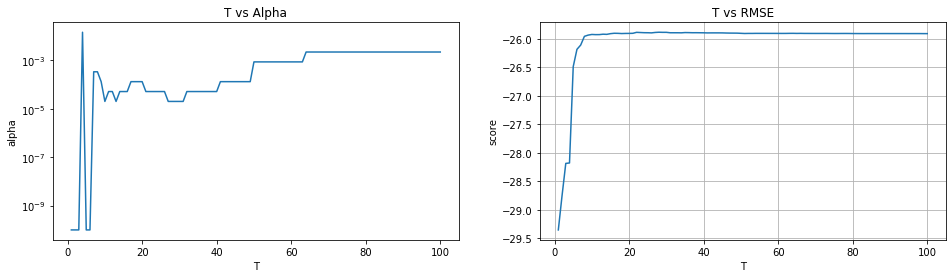

In [15]:
import pandas as pd
import seaborn as sns

results_dataframe = pd.DataFrame(results)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.lineplot(data=results_dataframe, x="T", y="alpha", ax=ax1)
ax1.set_yscale("log")
sns.lineplot(data=results_dataframe, x="T", y="score", ax=ax2)

ax1.set_title("T vs Alpha")
ax2.set_title("T vs RMSE")
plt.grid()

print("Best RMSE:", -grid_search.best_score_)

In [16]:
results_dataframe.sort_values(by="score", ascending=False).head()

,score,alpha,T,K,model
27,-25.880405,0.000020,28,8,"AutoregressiveELMRidgeEstimator(K=8, T=28, alp..."
29,-25.882039,0.000020,30,8,"AutoregressiveELMRidgeEstimator(K=8, T=30, alp..."
21,-25.882101,0.000052,22,8,"AutoregressiveELMRidgeEstimator(K=8, T=22, alp..."
28,-25.882198,0.000020,29,8,"AutoregressiveELMRidgeEstimator(K=8, T=29, alp..."
26,-25.883899,0.000020,27,8,"AutoregressiveELMRidgeEstimator(K=8, T=27, alp..."


In [17]:
best_model = results_dataframe.sort_values(by="score", ascending=False)["model"].head(1).item()

In [18]:
test_rmse = best_model.score(test_split)
print("Test RMSE:", -test_rmse)

Test RMSE: 25.580802242582198
